In [1]:
import os

from typing import Tuple, Dict, Any

import pandas as pd
import numpy as np
import jax.numpy as jnp

import numpyro

import pickle

In [2]:
GREEN_RGB_COLORS = [
    '#004c00',  # '#004e00', '#005000', '#005100', '#005300',
    # '#005500', # '#005700', '#005900', '#005a00', '#005c00',
    '#005e00',  # '#006000', '#006200', '#006300', '#006500',
    # '#006700', # '#006900', '#006b00', '#006c00', '#006e00',
    '#007000',  # '#007200', '#007400', '#007500', '#007700',
    # '#007900', # '#007b00', '#007d00', '#007e00', '#008000',
    '#008200',  # '#008400', '#008600', '#008800', '#008900',
    # '#008b00', # '#008d00', '#008f00', '#009100', '#009200',
    '#009400',  # '#009600', '#009800', '#009a00', '#009b00',
    # '#009d00', # '#009f00', '#00a100', '#00a300', '#00a400',
    '#00a600',  # '#00a800', '#00aa00', '#00ac00', '#00ad00',
    # '#00af00', # '#00b100', '#00b300', '#00b500', '#00b600',
    '#00b800',  # '#00ba00', '#00bc00', '#00be00', '#00bf00',
    # '#00c100', # '#00c300', '#00c500', '#00c700', '#00c800',
    '#00ca00',  # '#00cc00', '#00ce00', '#00d000', '#00d100',
    # '#00d300', # '#00d500', '#00d700', '#00d900', '#00da00',
    '#00dc00',  # '#00de00', '#00e000', '#00e200', '#00e300',
    # '#00e500', # '#00e700', '#00e900', '#00eb00', '#00ec00',
    '#00ee00',  # '#00f000', '#00f200', '#00f400', '#00f500',
    # '#00f700', # '#00f900', '#00fb00', '#00fd00', '#00ff00'
]

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
num_chains = 10
n_devices = min(os.cpu_count(), num_chains)
os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={n_devices}'

import jax

print(f"Default backend for JAX: {jax.default_backend()}")
print(
    f"Number of devices available on default backend: "
    f"{jax.local_device_count(backend=jax.default_backend())}"
)

Default backend for JAX: cpu
Number of devices available on default backend: 10


In [4]:
from namgcv.basemodels.bnam import BayesianNAM
from namgcv.configs.experimental.autompg_nam import DefaultBayesianNAMConfig
from namgcv.configs.experimental.autompg_nn import DefaultBayesianNNConfig

2025-03-13 13:44:31,223 - datasets - INFO - PyTorch version 2.6.0 available.
2025-03-13 13:44:31,238 - datasets - INFO - JAX version 0.4.28 available.


In [5]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml(
    "autompg",
    as_frame=True,
    return_X_y=True,
    version=1
)

# One hot encode the categorical features.
cat_features = pd.get_dummies(
    data=X[[col for col in X.columns if X[col].dtype == "category"]]
).astype(int)
num_features = X[[col for col in X.columns if X[col].dtype != "category"]]
print(f"Categorical features: {cat_features.columns.tolist()}")
print(f"Numeric features: {num_features.columns.tolist()}")

Categorical features: ['cylinders_3', 'cylinders_4', 'cylinders_5', 'cylinders_6', 'cylinders_8', 'model_70', 'model_71', 'model_72', 'model_73', 'model_74', 'model_75', 'model_76', 'model_77', 'model_78', 'model_79', 'model_80', 'model_81', 'model_82', 'origin_1', 'origin_2', 'origin_3']
Numeric features: ['displacement', 'horsepower', 'weight', 'acceleration']


In [ ]:
num_evals = 1

numpyro.set_host_device_count(
    DefaultBayesianNAMConfig().num_chains
)
all_runs_models = []
for eval_num in range(num_evals):
    model = BayesianNAM(
        cat_feature_info={
            feature_name: {
                "input_dim": 1,
                "output_dim": 1  # Mean regression only.
            } for feature_name in cat_features.columns
        },
        num_feature_info={
            feature_name: {
                "input_dim": 1,
                "output_dim": 1  # Mean regression only.
            } for feature_name in num_features.columns
        },
        config=DefaultBayesianNAMConfig(),
        subnetwork_config=DefaultBayesianNNConfig()
    )
    model.train_model(
        num_features={
            feature_name: jnp.array(
                num_features.iloc[:, col_idx]
            ) for col_idx, feature_name in enumerate(num_features.columns)
        },
        cat_features={
            feature_name: jnp.array(
                cat_features.iloc[:, col_idx]
            ) for col_idx, feature_name in enumerate(cat_features.columns)
        },
        target=jnp.array(y),
    )
    all_runs_models.append(model)

2025-03-13 13:44:31,528 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-13 13:44:31,528 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-13 13:44:31,528 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-13 13:44:31,528 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-13 13:44:31,528 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-13 13:44:31,528 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-13 13:44:31,528 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-13 13:44:31,528 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-13 13:44:31,540 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-13 13:44:31,542 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-13 13:44:31,542 - namgcv.basemodels.bnn - 

Epoch 11 | NLL=(Train:[12.673, 10.635, 10.820, 12.351, 13.103, 13.491, 10.688, 13.009, 13.561, 11.768], Val:[12.673, 10.635, 10.820, 12.351, 13.103, 13.491, 10.688, 13.009, 13.561, 11.768]) | RMSE=(Train:[15.063, 16.280, 15.625, 14.561, 14.326, 13.931, 16.184, 13.789, 13.819, 15.352], Val:[15.063, 16.280, 15.625, 14.561, 14.326, 13.931, 16.184, 13.789, 13.819, 15.352]):   2%|▏         | 12/500 [00:35<24:21,  2.99s/it]
  2%|▏         | 12/500 [00:35<24:21,  2.99s/it]


2025-03-13 13:45:19,938 - namgcv.basemodels.bnam - INFO - (Test NLL=[12.750, 10.171, 10.854, 12.289, 13.126, 13.400, 10.625, 12.948, 13.419, 11.964] | Test RMSE=[14.539, 16.546, 15.582, 14.378, 14.038, 13.726, 16.122, 13.680, 13.832, 14.994])
2025-03-13 13:45:20,057 - namgcv.basemodels.bnam - INFO - Finished warm-start training for chain 1 of 10.
2025-03-13 13:45:20,104 - namgcv.basemodels.bnam - INFO - Deep Ensemble 0 saved to C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\..\bnam_de_warmstart_checkpoints\warmstart
2025-03-13 13:45:20,127 - namgcv.basemodels.bnam - INFO - Deep Ensemble 1 saved to C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\..\bnam_de_warmstart_checkpoints\warmstart
2025-03-13 13:45:20,136 - namgcv.basemodels.bnam - INFO - Deep Ensemble 2 saved to C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\..\bnam_de

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

In [1]:
def plot_feature_contributions(
        num_features: dict,
        cat_features: dict,
        interaction_features: dict,
        submodel_contributions: dict,
        num_outputs: int
):
    """
    Plots feature contributions for numerical, categorical, and interaction features.
    Now includes a separate heatmap panel for the uncertainty of interaction features.
    Args:
        num_features (Dict[str, jnp.ndarray]):
            Dictionary of numerical features.
        cat_features (Dict[str, jnp.ndarray]):
            Dictionary of categorical features.
        interaction_features (Dict[str, jnp.ndarray]):
            Dictionary of interaction features.
        submodel_contributions (Dict[str, np.ndarray]):
            Dictionary of feature contributions with keys as feature names and values
            as numpy arrays of shape [num_samples, batch_size].
        target (jnp.ndarray):
            Target variable.
        aleatoric_uncertainty (Dict[str, jnp.ndarray]):
            Dictionary of aleatoric uncertainty estimates for each feature.
    """

    sns.set_style("whitegrid", {"axes.facecolor": ".9"})
    # Plot numerical features
    for feature_dict in [num_features, cat_features, interaction_features]:
        if not feature_dict:
            continue

        num_plots = len(feature_dict)
        fig, ax = plt.subplots(
            nrows=num_plots, ncols=num_outputs,
            figsize=(12*num_outputs, 6 * num_plots),
            squeeze=False
        )
        for i, (feature_name, feature_array) in enumerate(feature_dict.items()):
            feature_values = np.array(feature_array).flatten()  # Convert JAX array to NumPy

            # Shape: [num_mcmc_samples, batch_size, network_output_dim]
            contributions = submodel_contributions[feature_name]

            # [batch_size, network_output_dim]
            mean_contribution_all_params = contributions.mean(axis=0)
            for j in range(num_outputs):
                mean_param_contribution = mean_contribution_all_params[:, j] if num_outputs > 1 else mean_contribution_all_params

                # Create vertical colored bars with color intensity based on density
                sorted_idx = np.argsort(feature_values)
                feature_values_sorted = feature_values[sorted_idx]
                mean_param_contribution_sorted = mean_param_contribution[sorted_idx]

                ax_to_plot = ax[i, j]
                # Plot the centered partial contributions.
                sns.lineplot(
                    x=feature_values_sorted,
                    y=mean_param_contribution_sorted,
                    color=GREEN_RGB_COLORS[0],
                    label="Mean Output Parameter Contribution",
                    ax=ax_to_plot,
                    drawstyle="steps" if np.all(np.isin(feature_values, [0, 1])) else None
                )

                uncertainty = np.std(
                    submodel_contributions[feature_name][:, :, j],
                    axis=0
                )[sorted_idx] \
                    if num_outputs > 1 \
                    else np.std(
                        submodel_contributions[feature_name],
                        axis=0
                    )[sorted_idx]
                ax_to_plot.fill_between(
                    feature_values_sorted,
                    mean_param_contribution_sorted - 1.96 * uncertainty,
                    mean_param_contribution_sorted + 1.96 * uncertainty,
                    alpha=0.3,
                    color=GREEN_RGB_COLORS[-5],
                    label="Epistemic Uncertainty - 95% Interval"
                )

                num_bins = 30
                counts, bin_edges = np.histogram(feature_values, bins=num_bins)
                norm_counts = counts / counts.max()
                fixed_height = ax_to_plot.get_ylim()[1] - ax_to_plot.get_ylim()[0]
                for k in range(num_bins):
                    ax_to_plot.bar(
                        bin_edges[k],
                        height=fixed_height,
                        bottom=ax_to_plot.get_ylim()[0],
                        width=bin_edges[k + 1] - bin_edges[k],
                        color=plt.cm.Blues(norm_counts[k]),
                        alpha=0.3
                    )

                ax_to_plot.set_xlabel(f"{feature_name}", fontsize=12)
                ax_to_plot.set_ylabel("Feature Contribution", fontsize=12)
                ax_to_plot.set_title(f"Feature Contribution for {feature_name}", fontsize=12)
                ax_to_plot.legend(loc='best', fontsize=12, frameon=False)
                ax_to_plot.grid(True)

        plt.tight_layout()
        plt.show()

Empirical coverage of 90% prediction interval: 0.425


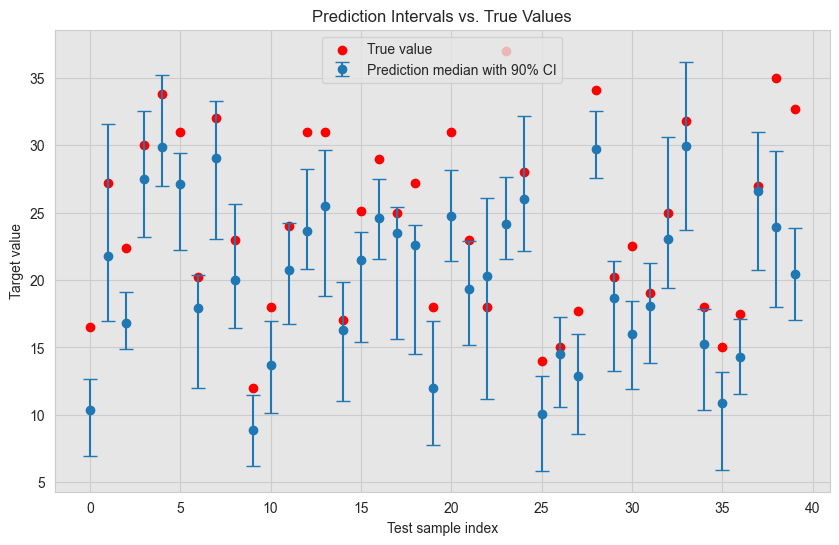

Mean CRPS: 3.237


In [35]:
def evaluate_calibration(
        pred_samples,
        y_test
):
    """
    This function will generate a plot, which displays the true frequency of points in each confidence interval relative to the predicted fraction of points in that interval.
    The closer the points are to the diagonal, the better the calibration.

    Formally, we choose m confidence levels 0<=p_1<=...<=p_m<=1. Then, for each threshold p_j, we compute the empirical frequency p_j_hat.

    calibration = sum_{j=1}^m (p_j_hat - p_j)**2

    Parameters
    ----------
    Returns
    -------
    """
    from properscoring import crps_ensemble  # Install via: pip install properscoring

    # --- Assumptions ---
    # model: your Bayesian NAM model that outputs predictive samples in regression
    # X_test: test input data
    # y_test: true target values (continuous)
    # --- End assumptions ---


    lower_quantile = 5  # 5th percentile
    upper_quantile = 95 # 95th percentile

    lower_bounds = np.percentile(pred_samples, lower_quantile, axis=0)
    upper_bounds = np.percentile(pred_samples, upper_quantile, axis=0)

    # Calculate the empirical coverage: fraction of true targets within the prediction intervals
    coverage = np.mean((y_test >= lower_bounds) & (y_test <= upper_bounds))
    print(f"Empirical coverage of 90% prediction interval: {coverage:.3f}")

    # Plot a subset of predictions with their uncertainty intervals
    n_plot = min(50, len(y_test))  # Plot at most 50 examples for clarity
    indices = np.random.choice(len(y_test), n_plot, replace=False)
    plt.figure(figsize=(10, 6))
    plt.errorbar(range(n_plot),
                 np.median(pred_samples[:, indices], axis=0),
                 yerr=[np.median(pred_samples[:, indices], axis=0) - lower_bounds[indices],
                       upper_bounds[indices] - np.median(pred_samples[:, indices], axis=0)],
                 fmt='o', capsize=5, label='Prediction median with 90% CI')
    plt.scatter(range(n_plot), y_test[indices], color='red', label='True value')
    plt.xlabel("Test sample index")
    plt.ylabel("Target value")
    plt.title("Prediction Intervals vs. True Values")
    plt.legend()
    plt.show()

    # --- Optional: Compute the Continuous Ranked Probability Score (CRPS) ---
    # CRPS is a proper scoring rule for probabilistic forecasts.
    # It measures the difference between the predicted distribution and the true outcome.
    # Lower CRPS values indicate better probabilistic calibration.
    crps = np.mean([crps_ensemble(y_test[i], pred_samples[:, i]) for i in range(len(y_test))])
    print(f"Mean CRPS: {crps:.3f}")


In [2]:
import jax.numpy as jnp
import numpyro.distributions as dist
from numpyro.infer import Predictive
from jax.scipy.special import logsumexp

def compute_negative_log_likelihood(
    model: BayesianNAM,
    split: str = "test",
    num_pp_samples: int = 100,
) -> float:
    """
    Compute the average negative log likelihood (NLL) of a dataset (train, val or test)
    using the model’s posterior predictive distribution.

    Parameters
    ----------
    model : BayesianNAM
        The Bayesian Neural Additive Model instance. It must have been trained so that
        model.posterior_samples is available and model.data_loader is initialized.
    split : str, optional
        Which split of the data to evaluate (e.g., "train", "valid", or "test"). Default is "test".
    num_pp_samples : int, optional
        Number of predictive samples to draw from the posterior predictive distribution.

    Returns
    -------
    float
        The average negative log likelihood over the dataset.

    Raises
    ------
    ValueError
        If posterior samples are not found or if the predicted parameters do not have the
        expected dimensions.
    """
    # Ensure that posterior samples are available.
    if model.posterior_samples is None:
        raise ValueError("Posterior samples not found. Please run MCMC sampling first.")

    # Set up the Predictive distribution using the model's MCMC posterior samples.
    predictive = Predictive(
        model.model,
        posterior_samples=model.posterior_samples,
        num_samples=num_pp_samples
    )

    # Get the data for the specified split (assumed to be full-batch).
    batch_iter = model.data_loader.iter(split=split, batch_size=None)
    data_batch = next(batch_iter)
    y_obs = data_batch["target"]  # shape: [batch_size, ...]

    # Generate posterior predictive samples.
    # (Note: The model.model function is written to accept the data_loader from the model.)
    preds = predictive(model._single_rng_key, data_loader=model.data_loader, is_training=False)

    # Extract the final distributional parameters.
    # For non-mixture models, we expect at least two parameters: (mu, sigma).
    # For mixture models, the model outputs parameters for each mixture component and separate mixture coefficients.
    final_params = preds["final_params"]  # shape: [num_pp_samples, batch_size, D]

    # Check if the model uses a mixture (num_mixture_components > 1).
    if model.config.num_mixture_components > 1:
        # Assume D is 2*k where k is the number of mixture components.
        k = model.config.num_mixture_components
        if final_params.shape[-1] < 2 * k:
            raise ValueError("Final parameters do not contain enough dimensions for a mixture model.")
        # Extract means and standard deviations for each mixture component.
        mu = final_params[..., :k]    # shape: [num_pp_samples, batch_size, k]
        sigma = final_params[..., k:2*k]  # shape: [num_pp_samples, batch_size, k]
        # Extract and normalize the mixture coefficients.
        mixture_coeff = preds["final_mixture_coefficients"]  # shape: [num_pp_samples, batch_size, k]
        # Construct a mixture of Normal distributions.
        comp_dist = dist.Normal(loc=mu, scale=sigma)
        mixture_dist = dist.MixtureSameFamily(
            mixing_distribution=dist.Categorical(probs=mixture_coeff),
            component_distribution=comp_dist
        )
        # Compute the log probability for each predictive sample.
        log_probs = mixture_dist.log_prob(y_obs)  # shape: [num_pp_samples, batch_size]
    else:
        # For the single-component case, expect at least two dimensions in final_params.
        if final_params.shape[-1] < 2:
            raise ValueError("Final parameters must include sigma for computing the likelihood.")
        mu = final_params[..., 0]      # shape: [num_pp_samples, batch_size]
        sigma = final_params[..., 1]   # shape: [num_pp_samples, batch_size]
        # Define the Normal distribution.
        single_dist = dist.Normal(loc=mu, scale=sigma)
        log_probs = single_dist.log_prob(y_obs)  # shape: [num_pp_samples, batch_size]

    # Average the log probabilities over the predictive samples using log-sum-exp.
    # This gives an estimate of the log predictive density for each data point.
    log_prob_mean = logsumexp(log_probs, axis=0) - jnp.log(num_pp_samples)  # shape: [batch_size]

    # Compute the negative log likelihood (average over data points).
    nll = -jnp.mean(log_prob_mean)

    return float(nll)

NameError: name 'BayesianNAM' is not defined

In [ ]:
for model in all_runs_models:
    final_params, _, submodel_contributions = model.predict()

    batch_iter = model.data_loader.iter(
        "test",
        batch_size=None
    )
    data_dict = next(batch_iter)  # First and only batch.
    num_features = data_dict["feature"]["numerical"]
    cat_features = data_dict["feature"]["categorical"]
    target = data_dict["target"]

    interaction_feature_information = {}
    all_features = {**num_features, **cat_features}
    for interaction_name in submodel_contributions.keys():
        if ":" not in interaction_name:
            continue

        feature_names = interaction_name.split(":")
        interaction_feature_information[interaction_name] = jnp.concatenate(
            [jnp.expand_dims(all_features[name], axis=-1) for name in feature_names],
            axis=-1
        )

    plot_feature_contributions(
            num_features=num_features,
            cat_features=cat_features,
            interaction_features=interaction_feature_information,
            submodel_contributions=submodel_contributions,
            num_outputs=1
    )

    # Compute the average negative log likelihood (NLL) of the test set.
    nll = compute_negative_log_likelihood(
        model=model,
        split="test",
        num_pp_samples=100
    )
    print(nll)

    evaluate_calibration(pred_samples=jnp.squeeze(final_params), y_test=target)


In [32]:
final_params.shape

(5000, 40, 1)